In [2]:
import numpy as np
from scipy.stats import dirichlet
import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma

def an_post(index, hm, xt, alpha):
    w0x = np.arange(1e-6, 1, 1/hm)
    x = tqdm.tqdm( w0x)
    w0y = []
    for w0 in x:
        w1x = np.arange(1e-6, 1-w0, 1/hm)
        w1y = []
        for w1 in w1x:
            w2 = 1-w0-w1
            if index == 0: w1y.append( np.exp( log_posterior(xt, np.array([w0, w1, w2]), alpha  ) ) ) 
            elif index == 1: w1y.append( np.exp( log_posterior(xt, np.array([w1, w0, w2]), alpha  ) ) ) 
            else: w1y.append( np.exp( log_posterior(xt, np.array([w2, w1, w0]), alpha  ) ) ) 
        w0y.append( np.trapz( np.array(w1y), w1x) )
    y = np.array(w0y)
    return w0x, y/np.trapz(y, w0x)

def generate_xt(n_pars, hm):
    xt = []
    for _ in range(hm):
        temp = np.linspace(10,1,n_pars) * np.random.uniform(0,1,n_pars)
        xt.append(temp/np.sum(temp))
    return np.array(xt)

def loglikelihood(xt, omega):
    return np.sum( np.log( np.array( [ np.sum(xt[i]*omega) for i in range(len(xt)) ] ) ) )

def log_posterior(xt, omega, alpha):
    return loglikelihood(xt, omega) + dirichlet.logpdf(omega, alpha = alpha)

def sampling(n, xt, alpha, alpha_prop):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    omega = np.hstack( dirichlet.rvs(alpha = alpha, size = 1) )
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        omega_new = np.hstack( dirichlet.rvs(alpha = alpha_prop, size = 1) )
        if log_rnd[i] <= log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_new):
            omega = omega_new
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def sampling2(n, xt, alpha, eps, each):
    accepted = []
    c = 0
    log_rnd = np.log(np.random.uniform(0,1,n))
    pb = tqdm.tqdm(range(n))
    x = np.ones(len(alpha)) * len(alpha)
    omega = x/np.sum(x)
    alp = 1/eps**2
    scale = x*eps**2
    for i in pb:
        acp = i and c/i or 0
        pb.set_description("Acceptance rate %f" % acp)
        x_pr = gamma.rvs(alp, scale = scale)
        omega_pr = x_pr/np.sum(x_pr)
        if i % each == 0: print(x_pr)
        if log_rnd[i] <= log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            omega = omega_pr
            x = x_pr
            scale = x_pr*eps**2
            c +=1
        accepted.append(omega)
    return np.array(accepted)

def log_acceptance_diri(xt, alpha, alpha_prop, omega, omega_pr):
    return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) - dirichlet.logpdf(omega_pr, alpha = alpha_prop) + dirichlet.logpdf(omega, alpha = alpha_prop)

def log_acceptance(xt, alpha, x, x_pr, omega, omega_pr, alp, eps, scale):
            scale_reverse = x_pr*eps**2
            return log_posterior(xt, omega_pr, alpha) - log_posterior(xt, omega, alpha) + log_jacobian(x_pr) - log_jacobian(x) + norm.logpdf(np.sum(x_pr), loc = 0, scale = 1) - norm.logpdf(np.sum(x), loc = 0, scale = 1) - np.sum( gamma.logpdf(x_pr, a = alp, scale=scale) ) + np.sum( gamma.logpdf(x, a = alp, scale=scale_reverse) )

def log_jacobian(x):
    return -(len(x)) * np.log(np.sum(x))



In [3]:
def w1_post(w1arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w1 in w1arr:
        y.append( ((1-w1)**(-1+a2+a3)*w1**(-1+a1)*(-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*y3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*y3*(x1-z1)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*y3*z1+a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*y3*z1+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y3*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y3*(x1-z1)*(x2-z2)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*z1*(x2-z2)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*z1*(x2-z2)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y3*z2+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y3*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y3*(x1-z1)*z2-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y3*(x1-z1)*z2-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y3*z1*z2-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y3*z1*z2-a2*(1+a2)*(2+a2)*(-1+w1)**3*y3*z1*z2+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*y2*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y2*(x1-z1)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*z1*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*z1*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*y1*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**3*(x1-z1)*(x2-z2)*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*z1*(x2-z2)*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*z1*(x2-z2)*(x3-z3)-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*z2*(x3-z3)-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*z2*(x3-z3)+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*z2*(x3-z3)+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*z2*(x3-z3)+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*z2*(x3-z3)+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*y2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*y2*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y2*(x1-z1)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y2*(x1-z1)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y2*z1*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y2*z1*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y2*z1*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*y1*(x2-z2)*z3-a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*y1*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1**2*(x1-z1)*(x2-z2)*z3+a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1**2*(x1-z1)*(x2-z2)*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*z1*(x2-z2)*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*z1*(x2-z2)*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*z1*(x2-z2)*z3-a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*y1*z2*z3-2*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*y1*z2*z3-a2*(1+a2)*(2+a2)*(-1+w1)**3*y1*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*w1*(x1-z1)*z2*z3+2*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*w1*(x1-z1)*z2*z3+a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*w1*(x1-z1)*z2*z3+(a2+a3)*(1+a2+a3)*(2+a2+a3)*z1*z2*z3+3*a2*(1+a2+a3)*(2+a2+a3)*(-1+w1)*z1*z2*z3+3*a2*(1+a2)*(2+a2+a3)*(-1+w1)**2*z1*z2*z3+a2*(1+a2)*(2+a2)*(-1+w1)**3*z1*z2*z3))/((a2+a3)*(1+a2+a3)*(2+a2+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w1arr)

def w2_post(w2arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w2 in w2arr:
        y.append( ((1-w2)**(-1+a1+a3)*w2**(-1+a2)*(-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*x3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*x3*(y1-z1)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*x3*z1+a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*x3*z1+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x3*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x3*(y1-z1)*(y2-z2)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*z1*(y2-z2)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*z1*(y2-z2)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x3*z2+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x3*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x3*(y1-z1)*z2-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x3*(y1-z1)*z2-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x3*z1*z2-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x3*z1*z2-a1*(1+a1)*(2+a1)*(-1+w2)**3*x3*z1*z2+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*x2*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x2*(y1-z1)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*z1*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*z1*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*x1*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**3*(y1-z1)*(y2-z2)*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*z1*(y2-z2)*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*z1*(y2-z2)*(y3-z3)-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*z2*(y3-z3)-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*z2*(y3-z3)+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*z2*(y3-z3)+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*z2*(y3-z3)+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*z2*(y3-z3)+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*x2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*x2*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x2*(y1-z1)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x2*(y1-z1)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x2*z1*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x2*z1*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x2*z1*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*x1*(y2-z2)*z3-a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*x1*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2**2*(y1-z1)*(y2-z2)*z3+a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2**2*(y1-z1)*(y2-z2)*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*z1*(y2-z2)*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*z1*(y2-z2)*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*z1*(y2-z2)*z3-a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*x1*z2*z3-2*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*x1*z2*z3-a1*(1+a1)*(2+a1)*(-1+w2)**3*x1*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*w2*(y1-z1)*z2*z3+2*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*w2*(y1-z1)*z2*z3+a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*w2*(y1-z1)*z2*z3+(a1+a3)*(1+a1+a3)*(2+a1+a3)*z1*z2*z3+3*a1*(1+a1+a3)*(2+a1+a3)*(-1+w2)*z1*z2*z3+3*a1*(1+a1)*(2+a1+a3)*(-1+w2)**2*z1*z2*z3+a1*(1+a1)*(2+a1)*(-1+w2)**3*z1*z2*z3))/((a1+a3)*(1+a1+a3)*(2+a1+a3)) )
    y = np.array(y)
    return y/np.trapz(y,w2arr)

def w3_post(w3arr, alpha, xt):
    a1,a2,a3 = alpha
    x1,y1,z1 = xt[0]
    x2,y2,z2 = xt[1]
    x3,y3,z3 = xt[2]
    y = []
    for w3 in w3arr:
        y.append( -(((1-w3)**(-1+a1+a2)*w3**(-1+a3)*(a1**3*((-1+w3)*x1-w3*z1)*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+a2*(2+3*a2+a2**2)*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+a1**2*(-3*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2*(-1+w3)*x3*((-1+w3)*y2-w3*z2)+3*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(3*(-1+w3)*x3+a2*(-1+w3)*y3-3*w3*z3-a2*w3*z3)+a2*w3*(y3*(z2-w3*z2)+(y2-w3*y2+2*w3*z2)*z3))+a2*((-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+w3*(y3*(z1-w3*z1)+(y1-w3*y1+2*w3*z1)*z3))-w3*((-1+w3)*x3*((-1+w3)*y2*z1+(-1+w3)*y1*z2-2*w3*z1*z2)+w3*(-((-1+w3)*y3*z1*z2)+y2*(z1-w3*z1)*z3+(y1-w3*y1+3*w3*z1)*z2*z3))))+a1*(-2*w3*z1*((-1+w3)*x2-w3*z2)*((-1+w3)*x3-w3*z3)+(-1+w3)*x1*(a2**2*((-1+w3)*y2-w3*z2)*((-1+w3)*y3-w3*z3)+2*w3*z2*(x3-w3*x3+w3*z3)+(-1+w3)*x2*(2*(-1+w3)*x3+a2*(-1+w3)*y3-2*w3*z3-a2*w3*z3)+a2*((-1+w3)*x3*((-1+w3)*y2-w3*z2)+(-1+w3)*y2*((-1+w3)*y3-2*w3*z3)+w3*z2*(-2*(-1+w3)*y3+3*w3*z3)))+a2*((-1+w3)*x3*((-1+w3)*y1*((-1+w3)*y2-2*w3*z2)+w3*z1*(-2*(-1+w3)*y2+3*w3*z2))+(-1+w3)*x2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)+(-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3))-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-3*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-3*w3*z3)+3*w3*z1*(y3-w3*y3+2*w3*z3))))+a2**2*((-1+w3)*x3*((-1+w3)*y1-w3*z1)*((-1+w3)*y2-w3*z2)+(-1+w3)*x2*((-1+w3)*y1-w3*z1)*((-1+w3)*y3-w3*z3)-w3*((-1+w3)*y2*((-1+w3)*y3*z1+(-1+w3)*y1*z3-2*w3*z1*z3)+z2*((-1+w3)*y1*((-1+w3)*y3-2*w3*z3)+w3*z1*(-2*(-1+w3)*y3+3*w3*z3)))))))/((a1+a2)*(1+a1+a2)*(2+a1+a2))) )
    y = np.array(y)
    return y/np.trapz(y,w3arr)

In [4]:
n_pars = 3
hm = 3
xt = generate_xt(n_pars, hm)
print(xt)

[[0.66281928 0.23321127 0.10396944]
 [0.27992351 0.67511852 0.04495796]
 [0.68290866 0.29284332 0.02424802]]


In [5]:
a = 0.5
alpha = np.ones(n_pars)*a
alpha_prop = np.ones(n_pars)

n = int(1e5)

samples = sampling(n, xt, alpha, alpha_prop)
eps = 1
each = int(1e4)
#samples2 = sampling2(n, xt, alpha, eps, each)

Acceptance rate 0.355682:   5%|▍         | 4937/100000 [00:02<00:54, 1747.56it/s]


KeyboardInterrupt: 

In [ ]:
anal_x = []
anal = []
for i in range(n_pars):
    x,y = an_post(i, 100, xt, alpha)
    anal_x.append(x)
    anal.append(y)


100%|██████████| 100/100 [00:00<00:00, 604.21it/s]


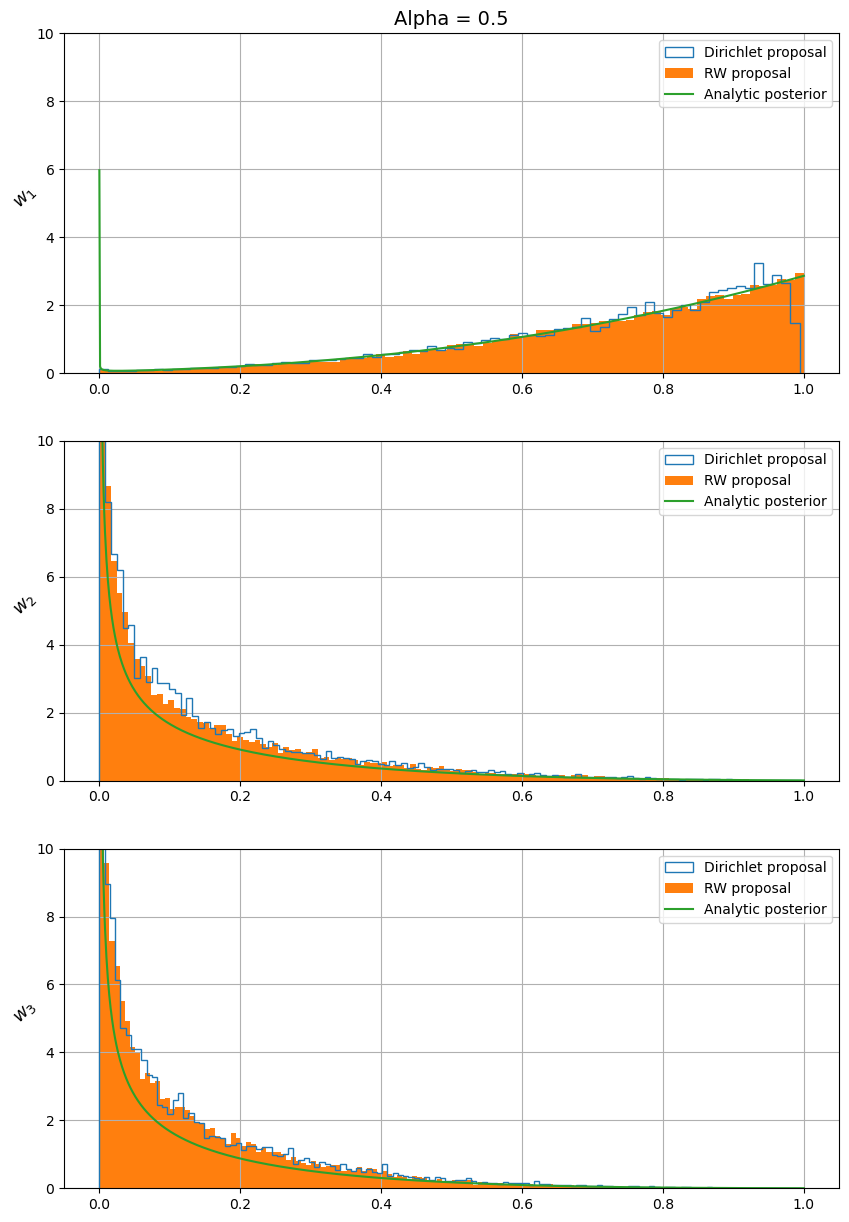

In [ ]:
fig, axs = plt.subplots( n_pars, figsize = [10,15] )
w = samples
w2 = samples2
x = np.arange(0, len(w[0]))
for i in range(n_pars):
    axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
    axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
    axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
    #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
    if i == 0 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 1 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
    if i == 2 : 
        xx = np.linspace(1e-6,1,1000)
        axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
    axs[i].grid()
    axs[i].legend()
    axs[i].set_ylim([0,10])
axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
plt.savefig('Alpha'+str(alpha[0])+'_second.png')
plt.show()
plt.close()

Acceptance rate 0.344037:   0%|          | 127/100000 [00:00<01:19, 1263.27it/s]

[0.13422765 3.19446089 0.53391239]


Acceptance rate 0.334508:  10%|█         | 10123/100000 [00:08<01:20, 1120.77it/s]

[5.81364411e-08 1.47509120e-08 4.28117273e-08]


Acceptance rate 0.337255:  20%|██        | 20161/100000 [00:16<01:05, 1223.91it/s]

[1.20246285e-05 1.92166304e-05 1.60937279e-04]


Acceptance rate 0.338337:  30%|███       | 30146/100000 [00:26<01:13, 953.80it/s] 

[1.76251888e-22 1.74996624e-22 1.70352795e-21]


Acceptance rate 0.339674:  40%|████      | 40130/100000 [00:37<01:03, 945.49it/s]

[1.50713947e-22 3.20952969e-24 3.67582507e-24]


Acceptance rate 0.339175:  50%|█████     | 50094/100000 [00:48<00:55, 904.57it/s]

[1.34725328e-35 7.94895630e-35 3.28460519e-36]


Acceptance rate 0.340192:  60%|██████    | 60163/100000 [00:58<00:42, 942.04it/s]

[1.50330335e-48 2.14800992e-46 2.87274660e-48]


Acceptance rate 0.339291:  70%|███████   | 70125/100000 [01:09<00:31, 941.90it/s]

[1.13874367e-49 2.38490468e-50 1.73390156e-49]


Acceptance rate 0.339757:  80%|████████  | 80111/100000 [01:20<00:20, 967.56it/s]

[2.91962631e-55 3.36506608e-56 2.07729455e-56]


Acceptance rate 0.339614:  90%|█████████ | 90097/100000 [01:30<00:10, 962.65it/s] 

[2.41874258e-71 1.63442238e-70 4.25942007e-72]


100%|██████████| 100/100 [00:00<00:00, 552.16it/s]


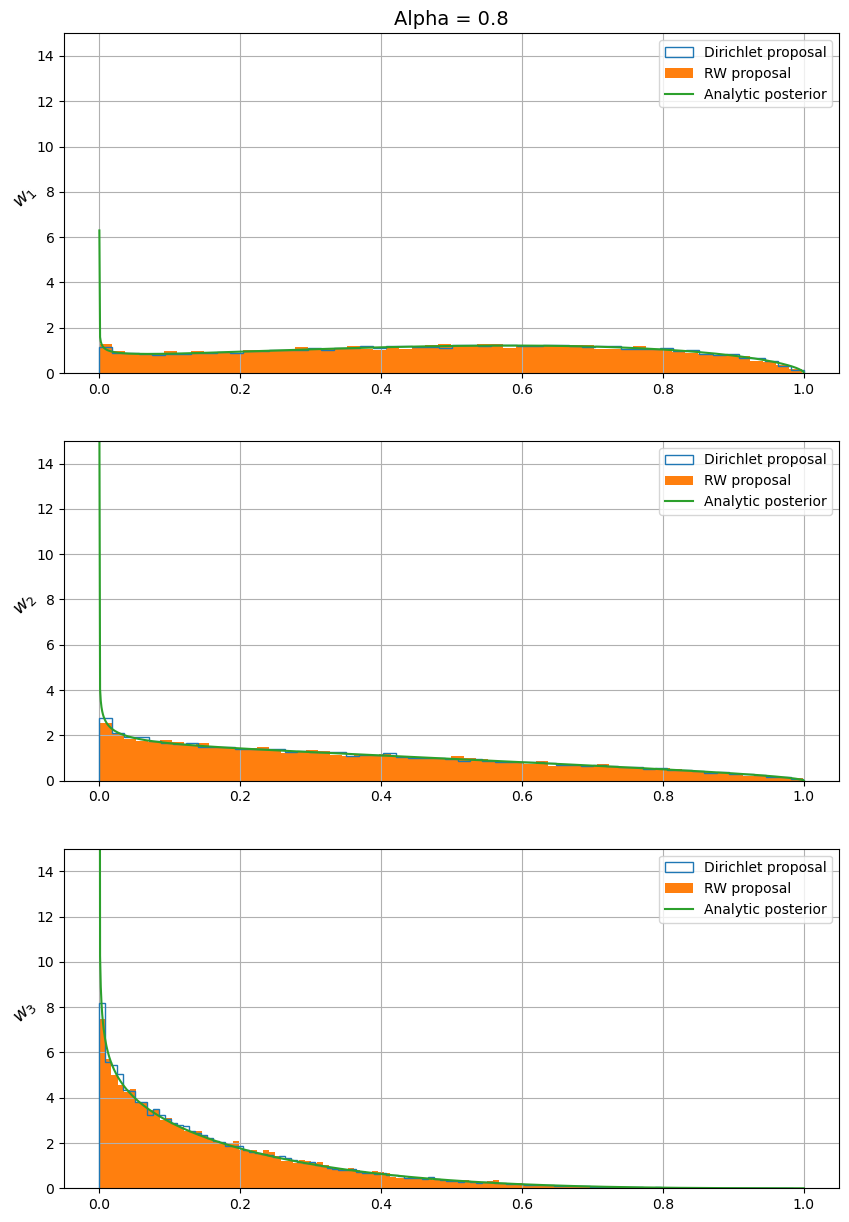

Acceptance rate 0.392670:   0%|          | 109/100000 [00:00<01:32, 1077.83it/s]

[1.78993203 0.44618793 0.6011653 ]


Acceptance rate 0.360063:  10%|█         | 10172/100000 [00:10<01:33, 962.05it/s]

[2.03052426e-19 1.39413308e-18 2.25742860e-19]


Acceptance rate 0.353784:  20%|██        | 20107/100000 [00:20<01:21, 981.71it/s]

[1.33901031e-16 3.82542032e-17 5.36989594e-19]


Acceptance rate 0.353233:  30%|███       | 30121/100000 [00:30<00:58, 1201.82it/s]

[4.85303313e-15 6.40430585e-15 1.26723536e-15]


Acceptance rate 0.354132:  40%|████      | 40183/100000 [00:38<00:49, 1213.11it/s]

[4.40347512e-22 5.53170490e-23 3.04748908e-23]


Acceptance rate 0.351785:  50%|█████     | 50119/100000 [00:47<00:41, 1212.96it/s]

[1.02058698e-15 4.08936901e-16 1.21903635e-14]


Acceptance rate 0.351263:  60%|██████    | 60092/100000 [00:55<00:33, 1177.30it/s]

[1.68859128e-19 1.01412887e-18 3.73775548e-19]


Acceptance rate 0.351504:  70%|███████   | 70195/100000 [01:05<00:24, 1212.85it/s]

[4.17076254e-13 2.44935549e-12 1.03756576e-12]


Acceptance rate 0.351515:  80%|████████  | 80106/100000 [01:13<00:16, 1210.14it/s]

[3.02110715e-13 2.24783574e-13 4.79677335e-15]


Acceptance rate 0.350955:  90%|█████████ | 90120/100000 [01:21<00:08, 1230.28it/s]

[0.78332317 0.00841816 0.00892639]


100%|██████████| 100/100 [00:00<00:00, 594.05it/s]


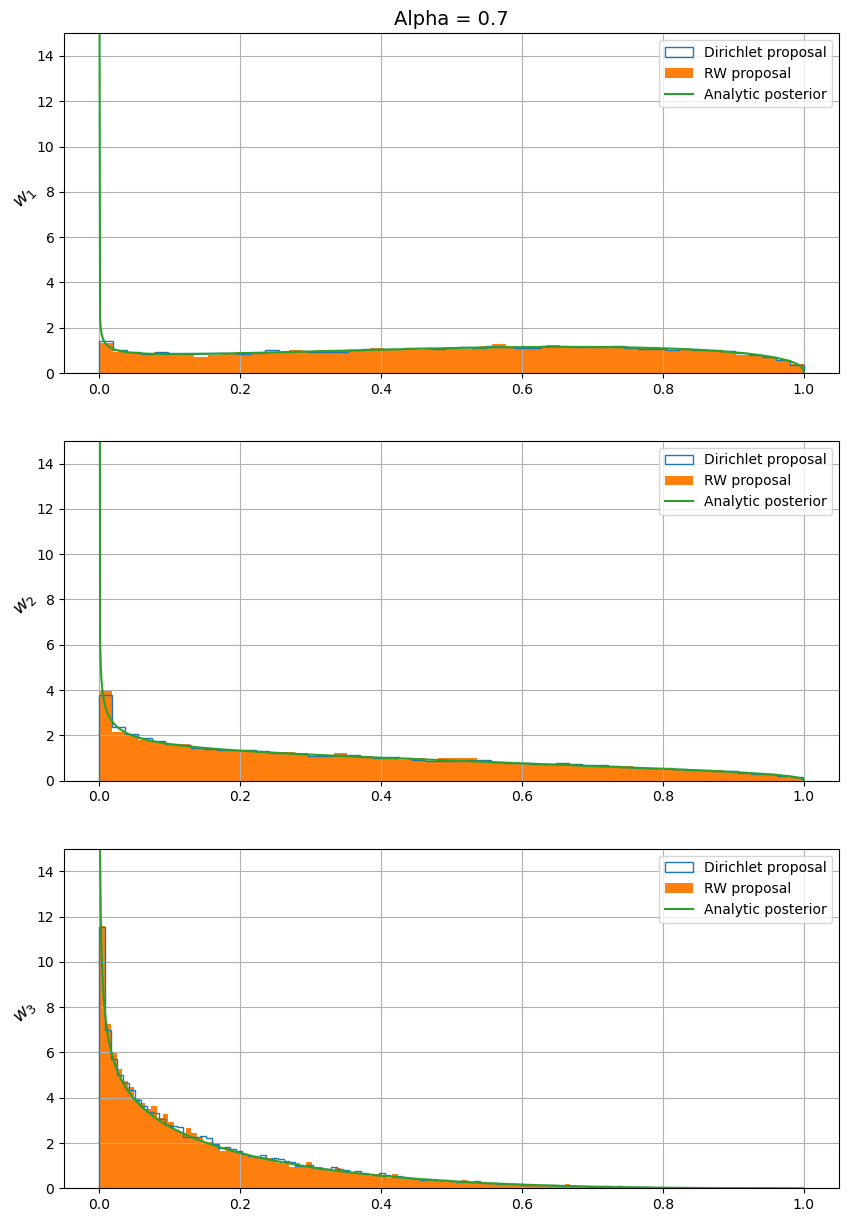

Acceptance rate 0.390244:   0%|          | 101/100000 [00:00<01:39, 999.53it/s]

[6.21622914 1.9339715  4.47972568]


Acceptance rate 0.365854:  10%|█         | 10127/100000 [00:10<01:32, 973.75it/s]

[1.43038358e+00 2.24846762e-01 1.21594933e-03]


Acceptance rate 0.364442:  20%|██        | 20157/100000 [00:20<01:19, 1007.10it/s]

[3.24499886e-06 6.47076534e-05 7.25585030e-07]


Acceptance rate 0.362551:  30%|███       | 30133/100000 [00:31<01:10, 997.23it/s] 

[5.21749444e-22 1.13461973e-21 5.11728601e-21]


Acceptance rate 0.360534:  40%|████      | 40074/100000 [00:41<01:01, 977.43it/s] 

[5.50163098e-25 1.20349809e-21 2.68571442e-24]


Acceptance rate 0.360152:  50%|█████     | 50132/100000 [00:51<00:51, 975.43it/s] 

[2.76083589e-24 3.89559541e-24 4.36260803e-26]


Acceptance rate 0.360727:  60%|██████    | 60131/100000 [01:01<00:41, 966.35it/s] 

[7.38619522e-24 8.80103846e-25 8.92664811e-24]


Acceptance rate 0.361476:  70%|███████   | 70103/100000 [01:12<00:35, 850.52it/s] 

[6.33650561e-20 6.48457981e-23 8.85261090e-21]


Acceptance rate 0.361761:  80%|████████  | 80178/100000 [01:22<00:20, 984.97it/s] 

[3.11490396e-31 2.14097447e-30 5.05298137e-32]


Acceptance rate 0.361907:  90%|█████████ | 90125/100000 [01:32<00:09, 1002.97it/s]

[7.31824207e-32 1.98295935e-30 1.43774852e-30]


100%|██████████| 100/100 [00:00<00:00, 543.43it/s]


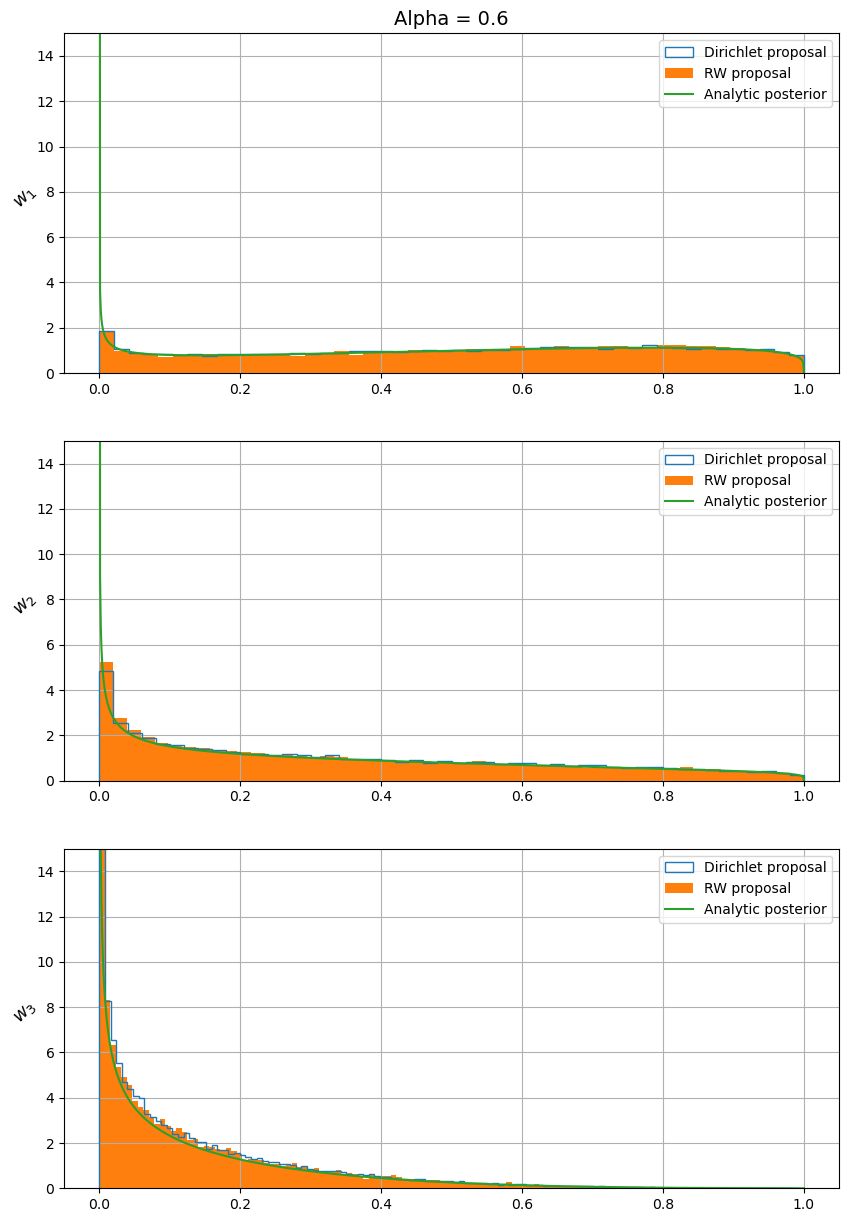

Acceptance rate 0.392405:   0%|          | 128/100000 [00:00<01:18, 1279.67it/s]

[1.63969595 2.78210116 1.74165265]


Acceptance rate 0.376799:  10%|█         | 10104/100000 [00:09<01:13, 1218.20it/s]

[1.48646235e-12 4.28895181e-13 3.73698135e-15]


Acceptance rate 0.379845:  20%|██        | 20100/100000 [00:18<01:21, 977.03it/s] 

[3.68443969e-12 1.51063271e-13 3.17370709e-13]


Acceptance rate 0.377097:  30%|███       | 30153/100000 [00:29<01:12, 963.30it/s] 

[1.89248156e-11 4.29301838e-11 8.09434126e-13]


Acceptance rate 0.377218:  40%|████      | 40101/100000 [00:39<01:03, 938.88it/s] 

[2.07733012e-24 5.30450989e-26 4.15974775e-25]


Acceptance rate 0.377383:  50%|█████     | 50124/100000 [00:49<00:49, 998.85it/s] 

[2.45183782e-25 4.86469454e-26 6.01179625e-28]


Acceptance rate 0.377165:  60%|██████    | 60107/100000 [00:59<00:40, 994.07it/s] 

[8.52407234e-05 2.10067501e-06 1.59914449e-06]


Acceptance rate 0.375732:  70%|███████   | 70081/100000 [01:09<00:30, 967.87it/s] 

[4.40866913e-09 4.92784853e-10 8.48030897e-14]


Acceptance rate 0.374894:  80%|████████  | 80164/100000 [01:20<00:19, 994.03it/s] 

[0.00054592 0.00193386 0.00012616]


Acceptance rate 0.374601:  90%|█████████ | 90185/100000 [01:30<00:09, 988.41it/s] 

[9.89833521e-02 7.85624876e-04 2.89124109e-05]


100%|██████████| 100/100 [00:00<00:00, 558.03it/s]


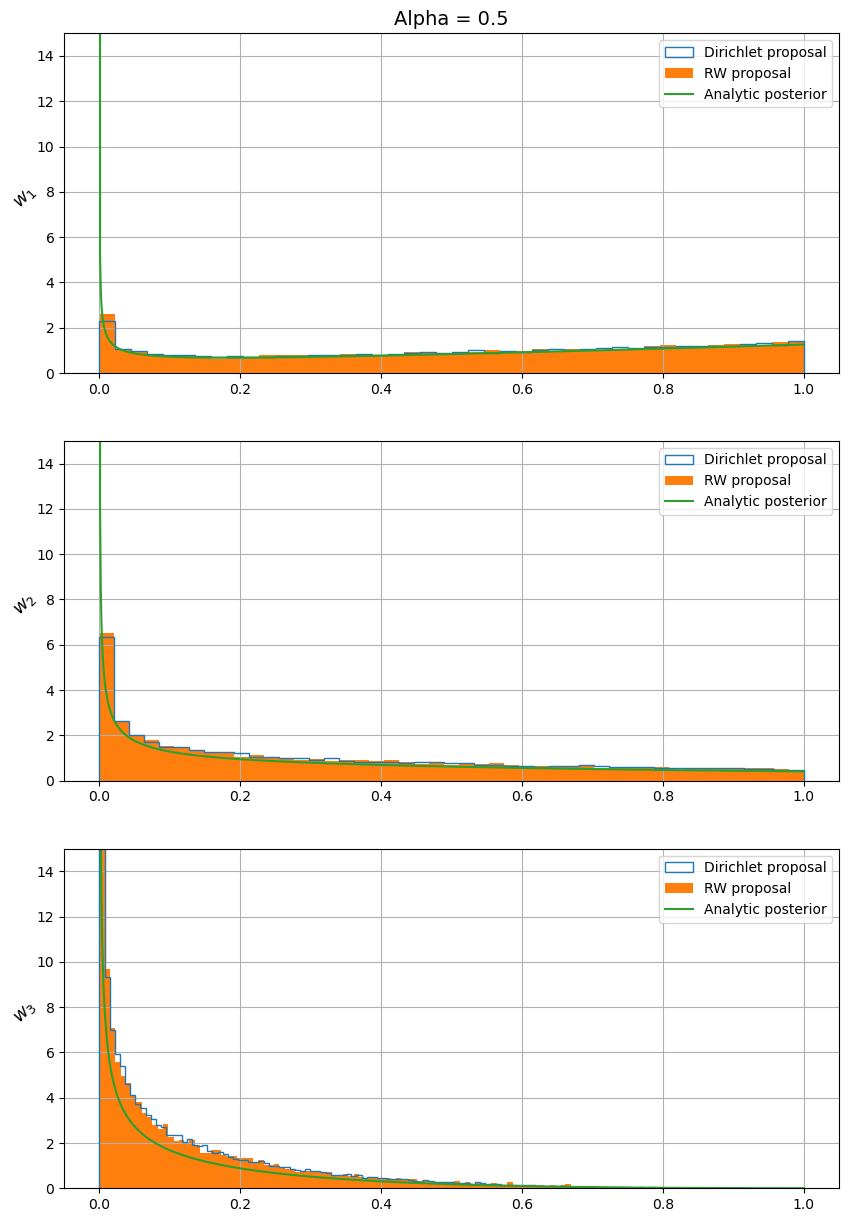

In [7]:

for a in [0.8, 0.7, 0.6, 0.5]:
    alpha = np.ones(n_pars)*a
    alpha_prop = alpha
    samples = sampling(n, xt, alpha, alpha_prop)
    eps = 1
    each = int(1e4)
    samples2 = sampling2(n, xt, alpha, eps, each)

    anal_x = []
    anal = []
    for i in range(n_pars):
        x,y = an_post(i, 100, xt, alpha)
        anal_x.append(x)
        anal.append(y)

    fig, axs = plt.subplots( n_pars, figsize = [10,15] )
    w = samples
    w2 = samples2
    x = np.arange(0, len(w[0]))
    for i in range(n_pars):
        axs[i].hist(np.transpose(w)[i], bins = 'auto', histtype='step', density = True, label = 'Dirichlet proposal')
        axs[i].hist(np.transpose(w2)[i], bins = 'auto', density = True, label = 'RW proposal')
        axs[i].set_ylabel(f'$w_{i+1}$', rotation = 45, size = '13')
        #axs[i].plot(anal_x[i], anal[i], label = 'Numerical posterior')
        if i == 0 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w1_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 1 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w2_post(xx, alpha, xt), label = 'Analytic posterior')
        if i == 2 : 
            xx = np.linspace(1e-6,1,1000)
            axs[i].plot(xx, w3_post(xx, alpha, xt), label = 'Analytic posterior')
        axs[i].grid()
        axs[i].legend()
        if a < 1:
            axs[i].set_ylim([0,15])
    axs[0].set_title(f'Alpha = {alpha[0]}', size = 14)
    plt.savefig('Alpha'+str(alpha[0])+'_third_sameA.png')
    plt.show()
    plt.close()

